In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optbinning as opt
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,KBinsDiscretizer, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import mannwhitneyu ,chi2_contingency, anderson, f_oneway
import statsmodels.api as sm 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import copy
from jenkspy import JenksNaturalBreaks
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

(CVXPY) Feb 26 03:34:53 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 26 03:34:53 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
data=pd.read_csv("../data/application_train_vf.csv",parse_dates=["date_mensuelle"], index_col=0)

In [3]:
data["TARGET"].value_counts(normalize=True) #desequilibre de classe

TARGET
0    0.923285
1    0.076715
Name: proportion, dtype: float64

In [4]:
# récupération de bureau (qq variables + imputation par 0)

credit_bureau_data=pd.read_csv("../data/cb_findings.csv", index_col=0)
data=data.merge(credit_bureau_data, left_on="SK_ID_CURR", right_on="CB_SK_ID_CURR")

In [5]:
pd.to_datetime(data["date_mensuelle"], format="%Y-%m-%d").dtypes

dtype('<M8[ns]')

In [6]:
data["HAS_CHILDREN"]=data["CNT_CHILDREN"].apply(lambda x : "Y" if x > 0 else "N")
data.drop(columns=["CNT_CHILDREN"], inplace=True)

In [7]:
drop_documents_cols=["FLAG_DOCUMENT_2","FLAG_DOCUMENT_3","FLAG_DOCUMENT_4" , 
"FLAG_DOCUMENT_5" , "FLAG_DOCUMENT_6","FLAG_DOCUMENT_7" ,              
"FLAG_DOCUMENT_8" , "FLAG_DOCUMENT_9","FLAG_DOCUMENT_10"  ,"FLAG_DOCUMENT_11" , "FLAG_DOCUMENT_12",              
"FLAG_DOCUMENT_13" ,"FLAG_DOCUMENT_14" ,"FLAG_DOCUMENT_15", "FLAG_DOCUMENT_16" ,
"FLAG_DOCUMENT_17", "FLAG_DOCUMENT_18","FLAG_DOCUMENT_19", "FLAG_DOCUMENT_20","FLAG_DOCUMENT_21"]

data.drop(columns=drop_documents_cols, inplace=True)

In [8]:
def convert_numeric_to_category(df: pd.DataFrame):
    for colname in df.columns.tolist():
        if (df[colname].dtype=="number") & (df[colname].nunique() <=10):
            df[colname]=df[colname].astype("category")
            pass
        else:
            pass

In [9]:
convert_numeric_to_category(data)

In [10]:
data["date_annee"]=data["date_mensuelle"].dt.year

out_of_sample_data=data[data["date_annee"]==2020]  # backtesting
data=data[data["date_annee"]<2020]

In [11]:
categorical_vars=data.select_dtypes(include="object").columns.tolist()

In [12]:
numerical_vars=data.select_dtypes(include="number").columns.tolist()

In [13]:
binary_vars=[var for var in numerical_vars if (data[var].nunique()==2)&(var !="TARGET")]

In [14]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [15]:
def mannwhitney_test(df:pd.DataFrame,variable:str,target:str):
    # Séparer les données en deux groupes en fonction de la variable cible
    group_1 = df[df[target] == 0]
    group_2 = df[df[target] == 1]

    stat, p_value = mannwhitneyu(group_1[variable].dropna(), group_2[variable].dropna())
    # Afficher les résultats
    print(f"Variable: {variable}")
    print(f"Mann-Whitney U-statistic: {stat}")
    print(f"P-value: {p_value}")
    print(10*"===")
    
    pass

In [16]:
def calculate_information_value_from_contingency_table(contingency_table):
    """
    Calculer l'Information Value à partir d'une table de contingence.
    
    Args:
        contingency_table (pd.DataFrame): La table de contingence entre la variable et la target.
        
    Returns:
        float: L'Information Value calculé.
    """
    non_event_rate=contingency_table.iloc[0]/(contingency_table.iloc[0].sum())
    event_rate=contingency_table.iloc[1]/(contingency_table.iloc[1].sum())
    iv=0
    if (non_event_rate.min() > 0) & (event_rate.mean() >0) :
        for col in non_event_rate.index:
            iv += (event_rate[col] - non_event_rate[col])*np.log(event_rate[col] / non_event_rate[col])

    return iv

In [17]:

def show_volume_stability_overtime(data:pd.DataFrame,colname:str):
        # Calcul des pourcentages pour chaque modalité au fil du temps
    resultats = data[[colname, "date_annee"]].groupby(by=["date_annee"]).value_counts(normalize=True).unstack().fillna(0)

    # Affichage des lineplots
    sns.set(style="whitegrid")
    resultats.plot(kind='line', marker='o', markersize=8)
    plt.title('Pourcentage de chaque modalité au fil du temps')
    plt.hlines(y=0.05, xmin=data["date_annee"].min(), xmax=data["date_annee"].max())
    plt.xlabel('Temps')
    plt.ylabel('Pourcentage')
    plt.legend(title=f"{colname}")
    plt.show()

In [18]:
def show_risk_stability_overtime(data:pd.DataFrame,colname:str):
    result = data.groupby([colname, "date_annee"])['TARGET'].value_counts(normalize=True).unstack().fillna(0)[1]

    # Tracer le lineplot
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=result.index.get_level_values("date_annee"), y=result.values, hue=result.index.get_level_values(f"{colname}"), marker='o')

    # Ajouter des étiquettes et un titre
    plt.xlabel('date_annee')
    plt.ylabel('Taux de défaut')
    plt.title(f"Taux de défaut en fonction de {colname} et année")

    # Ajouter une légende
    plt.legend(title=f"{colname}")

    # Afficher le graphique
    plt.show()
    

# Traitement des variables binaires

#### Test de stabilité en risque des variables binaires

In [19]:
binary_vars

['FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

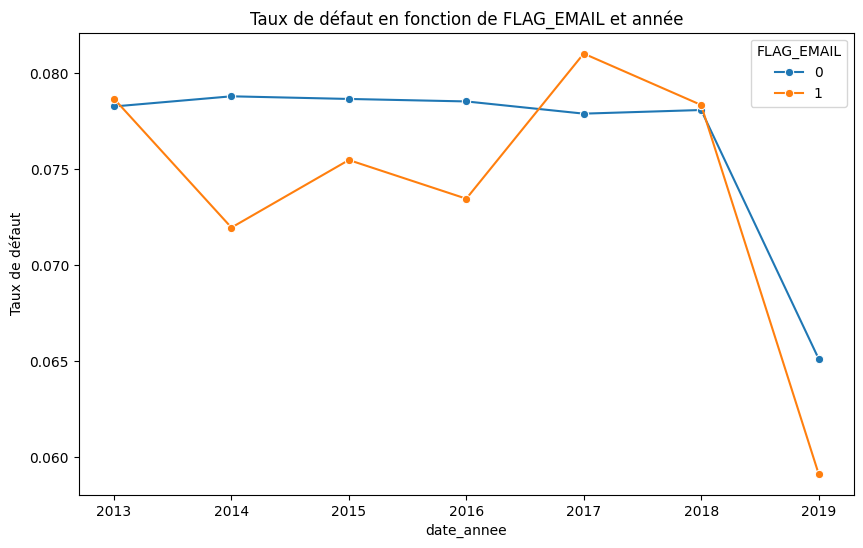

In [21]:
# montrer un plot 
show_risk_stability_overtime(data,"FLAG_EMAIL")

In [22]:
# dire pq elles sont non stables et qu'on les retire
binary_risk_non_stable_vars=["FLAG_MOBIL",
                             "FLAG_CONT_MOBILE",
                             "FLAG_EMAIL",
                             "REG_REGION_NOT_LIVE_REGION",
                             "REG_REGION_NOT_WORK_REGION",
                             "LIVE_REGION_NOT_WORK_REGION"]

In [23]:
binary_vars=list(filter(lambda x : x not in binary_risk_non_stable_vars, binary_vars))

In [24]:
#  variables binaires signif (pvalue)
for col in binary_vars:
    print(col)
    print(chi2_contingency(pd.crosstab(data["TARGET"], data[col].dropna())))
    print(60*"=")

FLAG_EMP_PHONE
Chi2ContingencyResult(statistic=541.1118770439443, pvalue=1.0803051842837344e-119, dof=1, expected_freq=array([[ 44627.12687913, 202668.87312087],
       [  3689.87312087,  16757.12687913]]))
FLAG_WORK_PHONE
Chi2ContingencyResult(statistic=200.62867268099427, pvalue=1.522798701766882e-45, dof=1, expected_freq=array([[198169.86169573,  49126.13830427],
       [ 16385.13830427,   4061.86169573]]))
FLAG_PHONE
Chi2ContingencyResult(statistic=152.80251594616982, pvalue=4.2309016724815076e-35, dof=1, expected_freq=array([[177762.21286831,  69533.78713169],
       [ 14697.78713169,   5749.21286831]]))
REG_CITY_NOT_LIVE_CITY
Chi2ContingencyResult(statistic=543.0070018670028, pvalue=4.1808917939176664e-120, dof=1, expected_freq=array([[227959.76428142,  19336.23571858],
       [ 18848.23571858,   1598.76428142]]))
REG_CITY_NOT_WORK_CITY
Chi2ContingencyResult(statistic=656.1838232140383, pvalue=1.009860040261178e-144, dof=1, expected_freq=array([[190480.62537583,  56815.37462417],

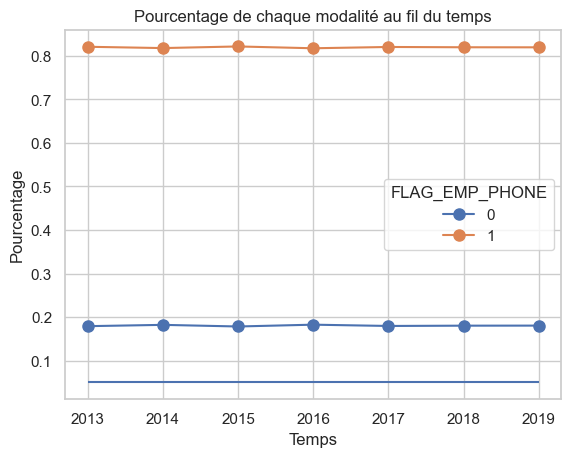

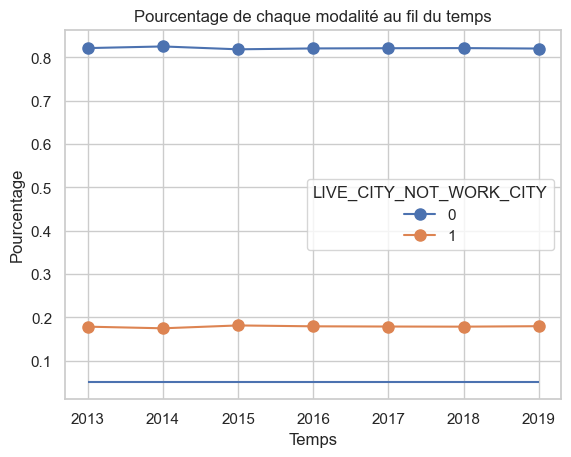

In [28]:
#### Test de stabilité en volume des variables binaires
exemple_var_bin = ["FLAG_EMP_PHONE", "LIVE_CITY_NOT_WORK_CITY"]
for var in exemple_var_bin :
    show_volume_stability_overtime(data,var)

In [29]:
binary_volume_non_stable_vars=[]
# variables à virer parmi les binaires:
binary_non_stable_vars=list(set(binary_volume_non_stable_vars+binary_risk_non_stable_vars))
binary_vars=list(filter(lambda x : x not in binary_non_stable_vars,binary_vars))
data.drop(columns=binary_non_stable_vars, inplace=True)

In [30]:
# on n'en vire aucune car toutes stables

In [31]:
numerical_vars=list(filter(lambda x : x not in binary_vars+binary_non_stable_vars,numerical_vars))

# Test de stabilité des variables catégorielles à faible modalité (2-4)

In [32]:
low_category_categorical_vars=[var for var in categorical_vars+numerical_vars if  (var not in binary_vars+binary_non_stable_vars+["TARGET"]) & (data[var].nunique()>=2) & (data[var].nunique()<=4)]
low_category_categorical_vars

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'EMERGENCYSTATE_MODE',
 'HAS_CHILDREN',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY']

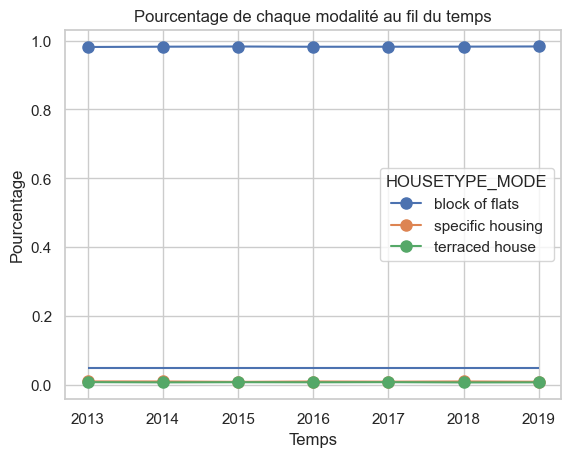

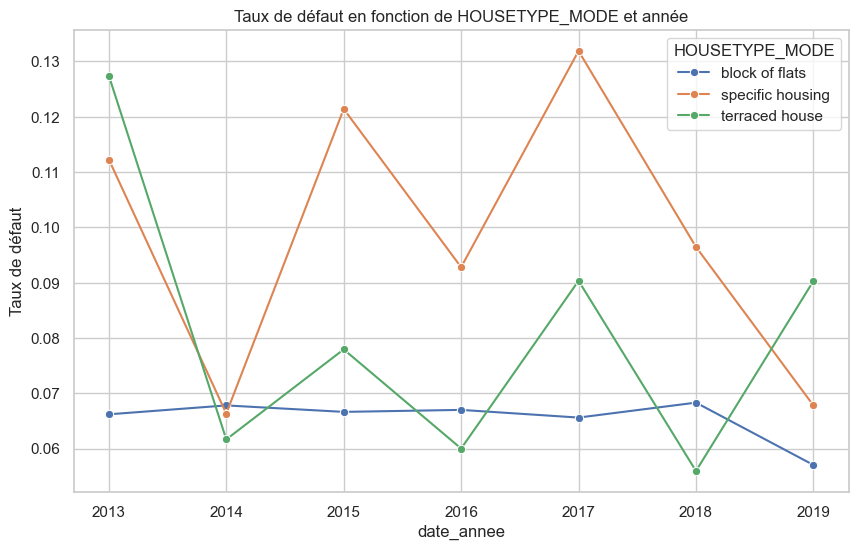

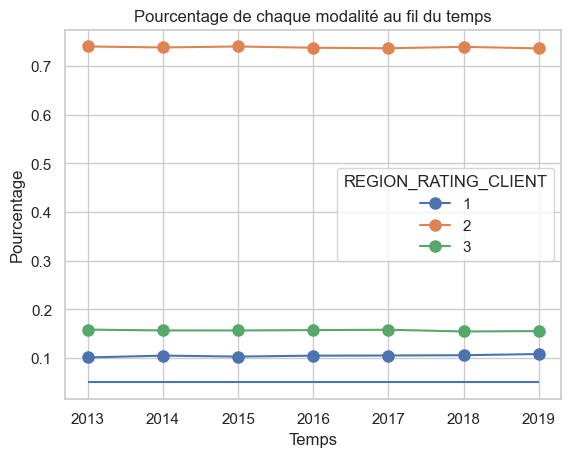

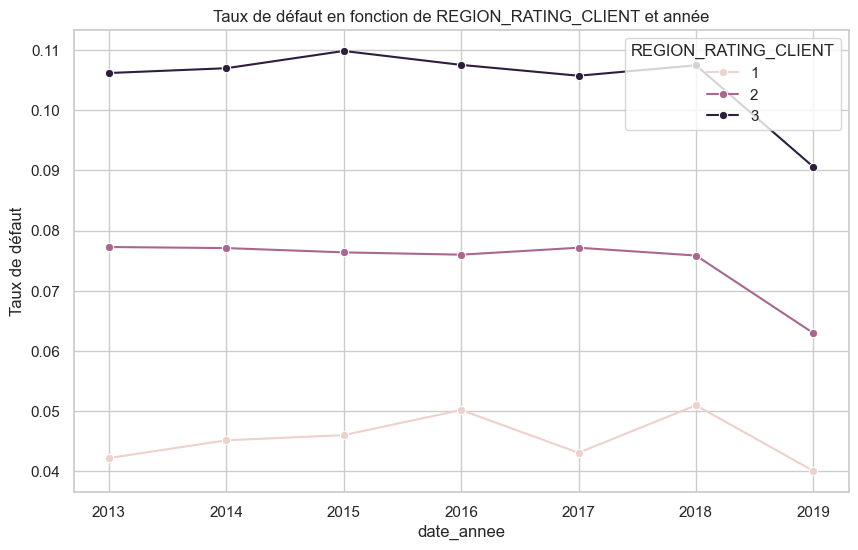

In [33]:
## en volume
exemple_low_cat = ["HOUSETYPE_MODE", "REGION_RATING_CLIENT"]
for colname in exemple_low_cat:
    show_volume_stability_overtime(data,colname)
    show_risk_stability_overtime(data,colname)


In [35]:
low_category_non_stable_vars=["FLAG_OWN_REALTY", "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "EMERGENCYSTATE_MODE"]
low_category_categorical_vars=list(filter(lambda x : x not in low_category_non_stable_vars,low_category_categorical_vars))
data["CODE_GENDER"]=data["CODE_GENDER"].apply(lambda x: "F" if x =="XNA" else x )
data.drop(columns=low_category_non_stable_vars, inplace=True)

# Test de stabilité des autres variables catégorielles

In [ ]:
# phrase : on a fait chi2, pvalue, v de cramer -> conclure

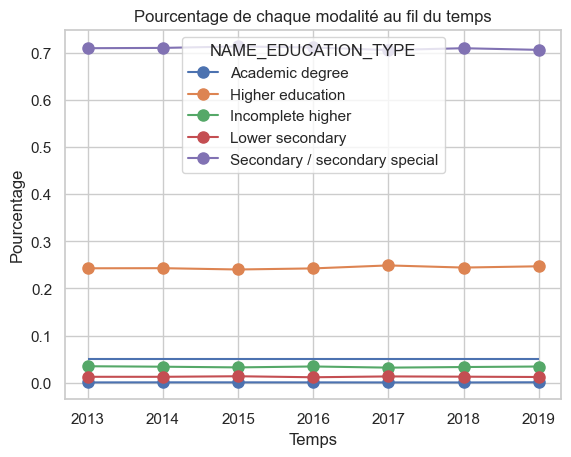

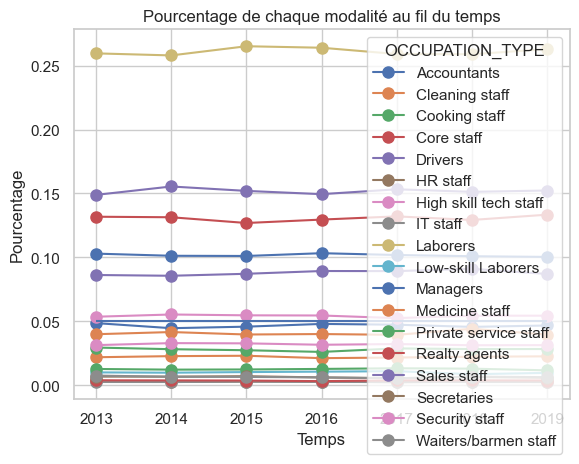

In [37]:
# [graphes] on trace la stabilité en volume dans le temps : on remarque bcp de modalités que l'on va regrouper

for col in ["NAME_EDUCATION_TYPE","OCCUPATION_TYPE"]:
    show_volume_stability_overtime(data,col)